# CNN으로 손글씨 숫자 이미지 분류하기

>### 1. 모듈 및 분석 환경 설정

>### 2. 데이터 불러오기

>### 3. 모델 학습

>### 4. 모델 평가

## 1.모듈 및 분석 환경 설정



* 모듈 불러오기

In [26]:
!pip install torch torchvision

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
%matplotlib inline

* 분석 환경 설정

In [35]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print('Current cuda device is', device)

Current cuda device is cuda


* HyperParameter 지정

In [36]:
batch_size = 50
epoch_num = 15
learning_rate = 0.0001

## 2. 데이터 불러오기

In [37]:
train_data = datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())  # transform : MNIST 데이터를 저장과 동시에 전처리
test_data = datasets.MNIST(root = './data', train = False, download = True, transform = transforms.ToTensor())

print('number of training data: ', len(train_data))
print('number of test data: ', len(test_data))

number of training data:  60000
number of test data:  10000


* MNIST 데이터 확인하기

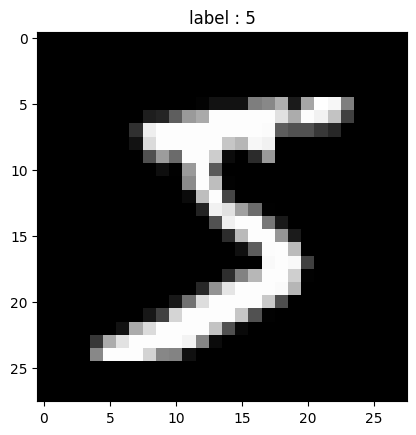

In [38]:
image, label = train_data[0]  # 첫번째 학습데이터의 입력 데이터와 정답 저장

plt.imshow(image.squeeze().numpy(), cmap = 'gray')  # [1,28,28] 3차원 -> [28,28] 2차원
plt.title('label : %s' %label)
plt.show()

* 미니 배치 구성하기

In [40]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)  # 학습 과정을 반복 시행할 때마다 미니 배치를 하나씩 불러옴
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)

first_batch = train_loader.__iter__().__next__()
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader)))  # 60000 / 50 = 1200 미니배치
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))  # [Batch Size, Channel, Width, Height]
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape))  # 미니 배치의 정답 50개

name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


데이터 한 개는 3차원이지만 데이터가 여러 개 쌓여 차원이 하나 더 늘어 4차원 Tensor가 된다.

* 모델 학습

<center>
<img src='https://drive.google.com/uc?id=1UGkfy6sUh_net-6_GPDhHoRpKXYEDXII' width="400" /><br>
</center>

In [41]:
class CNN(nn.Module):  # CNN 클래스 정의
    def __init__(self):  # 모델에서 사용되는 가중치 정의
        super(CNN, self).__init__()  # nn.Module 클래스의 속성을 상속받고 초기화
        self.conv1 = nn.Conv2d(1, 32, 3, 1)  # 입력채널, 출력채널, 커널, 스트라이드
        self.conv2 = nn.Conv2d(32, 64, 3, 1)  # conv1 출력채널 = conv2 입력채널
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)  # 9216크기의 벡터 -> 128크기의 벡터
        self.fc2 = nn.Linear(128, 10)  # 128크기의 벡터 -> 10크기의 벡터

    def forward(self, x):
        x = self.conv1(x)  # conv1 레이어 통과
        x = F.relu(x)  # ReLU 활성 함수 적용
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)  # 고차원의 Tensor를 1차원 벡터로 변환
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

* Optimizer 및 손실 함수 정의

In [42]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()  # 다중 클래스 분류 문제 -> 교차 엔트로피 사용

* 설계한 CNN 모형 확인하기

In [43]:
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


* 모델 학습

In [44]:
model.train()  # 학습 모드로 실행
i = 0
for epoch in range(epoch_num):
    for data, target in train_loader:
        data = data.to(device)  # 미니 배치의 데이터를 device에 할당
        target = target.to(device)
        optimizer.zero_grad()  # 학습 시작 전, optimizer의 gradient 초기화
        output = model(data)  # FeedForward 연산으로 결괏값 계산
        loss = criterion(output, target)  # 손실 함수 계산
        loss.backward()  # 손실 함수를 통해 Gradient 계산
        optimizer.step()  # Gradient 통해 모델의 가중치 업데이트
        if i % 1000 == 0:
            print('Train Step: {}\tLoss: {:.3f}'.format(i, loss.item()))  # 손실함수 출력
        i += 1

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Step: 0	Loss: 2.308
Train Step: 1000	Loss: 0.145
Train Step: 2000	Loss: 0.178
Train Step: 3000	Loss: 0.195
Train Step: 4000	Loss: 0.035
Train Step: 5000	Loss: 0.176
Train Step: 6000	Loss: 0.050
Train Step: 7000	Loss: 0.070
Train Step: 8000	Loss: 0.054
Train Step: 9000	Loss: 0.107
Train Step: 10000	Loss: 0.023
Train Step: 11000	Loss: 0.040
Train Step: 12000	Loss: 0.055
Train Step: 13000	Loss: 0.026
Train Step: 14000	Loss: 0.038
Train Step: 15000	Loss: 0.031
Train Step: 16000	Loss: 0.038
Train Step: 17000	Loss: 0.002


* 모델 평가

In [45]:
model.eval()  # 평가 모드 실행
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data)  # 미니 배치 데이터를 모델에 통과시켜 결괏값 계산
    prediction = output.data.max(1)[1]  # Log-Softmax 값이 가장 큰 인덱스를 예측값으로 저장
    correct += prediction.eq(target.data).sum()

print('Test set: Accuracy: {:.2f}%'.format(100. * correct / len(test_loader.dataset)))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Test set: Accuracy: 98.96%


output.data.max(1)[1]


output: 모델의 출력으로, 모델이 각 클래스에 대해 계산한 로그 확률값(Log probabilities)을 포함하는 Tensor입니다. 크기는 (배치 크기, 클래스 수)입니다.

.data: PyTorch에서 Tensor의 값을 직접 접근하기 위한 속성입니다. 이를 통해 Tensor의 값을 조작하고 검사할 수 있습니다. (단, .data를 사용할 때는 기울기 정보가 무시됩니다.)

.max(1): 각 행(row)에서 최댓값을 반환하는 함수입니다. 이 경우에는 각 데이터 샘플에 대해 최댓값과 해당 최댓값의 인덱스를 반환합니다. 반환값은 튜플 형태로 (최댓값, 최댓값의 인덱스)입니다.

[1]: 튜플의 두 번째 요소를 선택합니다. 여기서는 최댓값의 인덱스에 해당하는 부분입니다. 따라서 최종적으로 반환되는 값은 각 데이터 샘플에 대한 예측된 클래스의 인덱스를 나타내는 Tensor입니다.